# Empirical application II: input-output data

We estimate an input-output matrix using data from the Bureau of Economic Analysis (BEA). Based on this noisy estimate, we find coefficient-wise confidence intervals for the estimated network centralities.

In [1]:
using TimeSeries, Distributions, Statistics, LinearAlgebra, CSV, DataFrames, Random, Colors
iodata1 = DataFrame(CSV.File("data/t-17.csv",header=false,missingstring="---"));
iodata2 = DataFrame(CSV.File("data/t-18.csv",header=false,missingstring="---"));
iodata3 = DataFrame(CSV.File("data/t-19.csv",header=false,missingstring="---"));
iodata4 = DataFrame(CSV.File("data/t-20.csv",header=false,missingstring="---"));
iodata5 = DataFrame(CSV.File("data/t-21.csv",header=false,missingstring="---"));
iodata6 = DataFrame(CSV.File("data/t-22.csv",header=false,missingstring="---"));
DataFrameVector = [];
push!(DataFrameVector,iodata1,iodata2,iodata3,iodata4,iodata5,iodata6)

6-element Vector{Any}:
 17×17 DataFrame
 Row │ Column1  Column2                            Column3                     ⋯
     │ String7  String                             String                      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ code     Commodities/Industries             11                          ⋯
   2 │ code     Name                               Agriculture, forestry, fish
   3 │ 11       Agriculture, forestry, fishing, …  110551
   4 │ 21       Mining                             1344
   5 │ 22       Utilities                          9357                        ⋯
   6 │ 23       Construction                       1578
   7 │ 31G      Manufacturing                      67527
   8 │ 42       Wholesale trade                    43698
  ⋮  │    ⋮                     ⋮                                  ⋮           ⋱
  11 │ 51       Information                        1050                        ⋯
  12 │ FIRE     Finance, insur

In [2]:
#collect node information and reformat.
node_id_data = iodata1[3:17,1:2]
DataFrames.rename!(node_id_data,1 => :Code,2 => :Description);
node_id_data[!,:NodeOld] = 1:15

1:15

In [3]:
#make a loop through all tables and stitch them together, keep missing values missing
io_matrices = zeros(Union{Missing,Float64},size(node_id_data,1),size(node_id_data,1),6)

for (count,adjacency_mat) in enumerate(DataFrameVector)
    io_matrices[:,:,count] = passmissing(parse).(Float64,Matrix(adjacency_mat[3:17,3:size(adjacency_mat,2)]));
end

Convert this table to a sequence of adjacency matrices. We estimate the adjacency matrix $M$ by $\hat{M}$ as in Simons (2023). In particular, we average the first differences of the natural logarithm, which provides an estimate of the average growth rate. To account for potential serial correlation in the errors, we use a HAC estimator to estimate a robust covariance matrix. We interpret the nodes in the directed graph that have on average grown their trade balance the most and with most connections as the most central actors in the trade network and estimate eigenvector centralities and provide one-sided confidence intervals.

Check which nodes have missing values as the first observation.

In [4]:
missingmatrix = zeros(15,15);

for i in 1:15, j in i+1:15
    missingmatrix[i,j] = length(findall(ismissing.(io_matrices[i,j,:])));
    missingmatrix[j,i] = length(findall(ismissing.(io_matrices[j,i,:])));
end

first_entry_missing = zeros(Bool,12,12)
pairs_w_first_entry_missing = []
pairs_w_first_entry_notmissing = []

for i in 1:12, j in i:12
    first_entry_missing[i,j] = 1 == findfirst(ismissing.(io_matrices[i,j,:]));
    first_entry_missing[j,i] = 1 == findfirst(ismissing.(io_matrices[j,i,:]));
    if 1 == findfirst(ismissing.(io_matrices[i,j,:]))
        push!(pairs_w_first_entry_missing,[i j]) else
        push!(pairs_w_first_entry_notmissing,[i j])
    end;
    if 1 == findfirst(ismissing.(io_matrices[j,i,:]))
        push!(pairs_w_first_entry_missing,[j i]) else
        push!(pairs_w_first_entry_notmissing,[j i])
    end;
end
l = length(pairs_w_first_entry_missing)
#recall that reshape goes through the dimensions in order so exhausts the first dimension then the second etc.
pairs_to_eliminate = reshape(stack(pairs_w_first_entry_missing),(2,l))'
pairs_to_keep = reshape(stack(pairs_w_first_entry_notmissing),(2,length(pairs_w_first_entry_notmissing)))'
for row in eachrow(pairs_to_eliminate)
    println("First observation for pair [",row[1],", ",row[2],"] is ",io_matrices[row[1],row[2],1])
end
nodes_to_eliminate = unique(pairs_to_eliminate);
println("Nodes to eliminate",nodes_to_eliminate)

First observation for pair [1, 3] is missing
First observation for pair [1, 9] is missing
First observation for pair [12, 2] is missing
Nodes to eliminate

[1, 12, 3, 9, 2]


Eliminate nodes that have a missing value as the first observation and check that taking logarithms and first differences does not produce `NaN` or `Inf` entries.

In [5]:
T=6
t_start=1
p=15-length(nodes_to_eliminate);
trade_matrices_wm = io_matrices
trade_matrices_cf = zeros(Float64,p,p,T-t_start+1) #carried forward for missing values

k=0;
locf(v) = v[accumulate(max,[i*!ismissing(v[i]) for i=1:length(v)])]
row_indices = filter!(e -> e ∉(nodes_to_eliminate),collect(1:15))
node_hash_map = zeros(length(row_indices),2)
for i in enumerate(row_indices)
    node_hash_map[i[1],1] = i[2]; #put the old node in
    node_hash_map[i[1],2] = i[1]; #put the new node in
    col_indices = filter!(e -> e ∉(nodes_to_eliminate),collect(1:15))
    for j in enumerate(col_indices)
        trade_matrices_cf[i[1],j[1],:] = locf(trade_matrices_wm[i[2],j[2],:])
    end #j
end #i

#find first differences
trade_matrices_cf_fd = zeros(Float64,p,p,T-t_start+1-1)

function simple_check(x)
    any(isnan.(x)) || any(.!isfinite.(x))
end

for i in 1:p, j in i:p
    trade_matrices_cf_fd[i,j,:] = diff(log.(trade_matrices_cf[i,j,:]));
    trade_matrices_cf_fd[j,i,:] = diff(log.(trade_matrices_cf[j,i,:]));
    if simple_check(trade_matrices_cf_fd[i,j,:]) println("Nan or Inf at ",i," ",j) end
    if simple_check(trade_matrices_cf_fd[j,i,:]) println("Nan or Inf at ",j," ",i) end
end

Row,Code,Description
,String,String
1,23,Construction
2,31G,Manufacturing
3,42,Wholesale trade
4,44RT,Retail trade
5,48TW,Transportation and warehousing
6,FIRE,"Finance, insurance, real estate, rental, and leasing"
7,PROF,Professional and business services
8,7,"Arts, entertainment, recreation, accommodation, and food services"
9,81,"Other services, except government"


Merge tables with node information and node identifier.

In [15]:
using DataFrames

node_conversion_table = DataFrame(  NodeOld = node_hash_map[:,1],
            NodeNew = node_hash_map[:,2]);

#merge

label_conv_table = DataFrames.leftjoin(node_conversion_table,node_id_data,on=:NodeOld=>:NodeOld)
label_conv_table[!,:Description] = convert.(String,label_conv_table[!,:Description])
label_conv_table[!,:Code] = convert.(String,label_conv_table[!,:Code])

label_conv_table[:,3:4]

Row,Code,Description
,String,String
1,23,Construction
2,31G,Manufacturing
3,42,Wholesale trade
4,44RT,Retail trade
5,48TW,Transportation and warehousing
6,FIRE,"Finance, insurance, real estate, rental, and leasing"
7,PROF,Professional and business services
8,7,"Arts, entertainment, recreation, accommodation, and food services"
9,81,"Other services, except government"


Output table as `TexTable` to insert into table in the paper.

In [14]:
using TexTables
t1 = TableCol("Description",label_conv_table[:,3], label_conv_table[:,4])
#t2 = TableCol("Code",label_conv_table[:,3],label_conv_table[:,3])
to_tex(hcat(t1)) |> print

\begin{tabular}{r|c}
\toprule
     & Description                                                       \\ \hline
  23 &                                                      Construction \\
 31G &                                                     Manufacturing \\
  42 &                                                   Wholesale trade \\
44RT &                                                      Retail trade \\
48TW &                                    Transportation and warehousing \\
FIRE &              Finance, insurance, real estate, rental, and leasing \\
PROF &                                Professional and business services \\
   7 & Arts, entertainment, recreation, accommodation, and food services \\
  81 &                                 Other services, except government \\
   G &                                                        Government \\
\bottomrule
\end{tabular}

## Estimate centralities based on average growth rate

In [16]:
using CovarianceMatrices
include("eigenvector_estimates_cis.jl")
p = size(trade_matrices_cf_fd)[1];
T = size(trade_matrices_cf_fd)[3];
vectorised_matrices = reshape(trade_matrices_cf_fd,(p^2,T));
y = vectorised_matrices'
X   = ones(T,1)
_,K = size(X)
b   = X\y
res = y - X*b

kernel = QuadraticSpectralKernel{NeweyWest}()
bw = CovarianceMatrices.optimalbandwidth(kernel, res, prewhite=false);
Ψ   = lrvar(QuadraticSpectralKernel(bw), res, scale = T^2/(T-K))   # df adjustment is built into vcov
estimates_abs_tuple = eigenvector_estimates_cis_abs(trade_matrices_cf_fd ,1,0.05,false,Ψ);
estimates_abs = estimates_abs_tuple[1]
graph_estimate = estimates_abs_tuple[2];

Note that the array `estimates_abs` has the point estimates and upper bounds as the first two matrices and the value of the objective function for the finding of an upper bound as its third matrix. 

In [17]:
#make a table for the eigenvector centralities
eigenvector_centralities = DataFrame(   NodeOld = node_hash_map[:,1],
                                        NodeNew = node_hash_map[:,2],
                                        Sector = ["A","B","C","D","E","F","G","H","I","J"],
                                        LogCentrality = log.(estimates_abs[:,1,1]),
                                        LogCentrality_upper = log.(estimates_abs[:,1,2]),
                                        LogCentrality_error = log.(estimates_abs[:,1,2]) - log.(estimates_abs[:,1,1]),
                                        Centrality = estimates_abs[:,1,1],
                                        Centrality_upper = estimates_abs[:,1,2],
                                        Centrality_error = estimates_abs[:,1,2] - estimates_abs[:,1,1]
                                        );
eigenvector_centralities = leftjoin(eigenvector_centralities,label_conv_table,on = [:NodeOld => :NodeOld, :NodeNew => :NodeNew])
sort!(eigenvector_centralities,:Centrality_upper,rev=true)
CSV.write("network_statistics_io.csv",eigenvector_centralities)

"network_statistics_io.csv"

┌ Warning: backend `PGFPlotsX` is not installed.
└ @ Plots /Users/jerome/.julia/packages/Plots/7R93Y/src/backends.jl:43


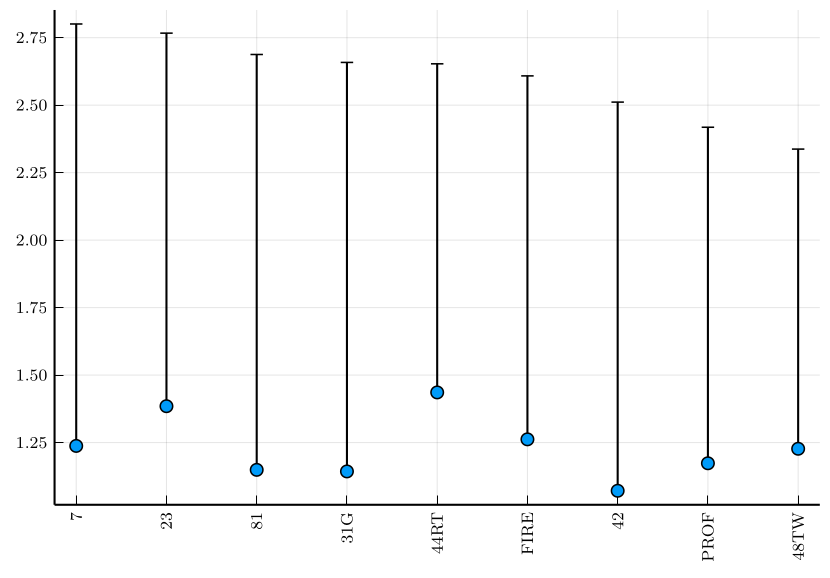

In [18]:
using Plots
pgfplotsx()
endrow = size(node_conversion_table)[1]-1
centralities_plot = plot(   eigenvector_centralities[1:endrow,:Code],
        eigenvector_centralities[1:endrow,:LogCentrality],
        yerr = (zeros(endrow),
                eigenvector_centralities[1:endrow,:LogCentrality_error]),
        linetype=:scatter,label="",xrotation = 90)
centralities_plot

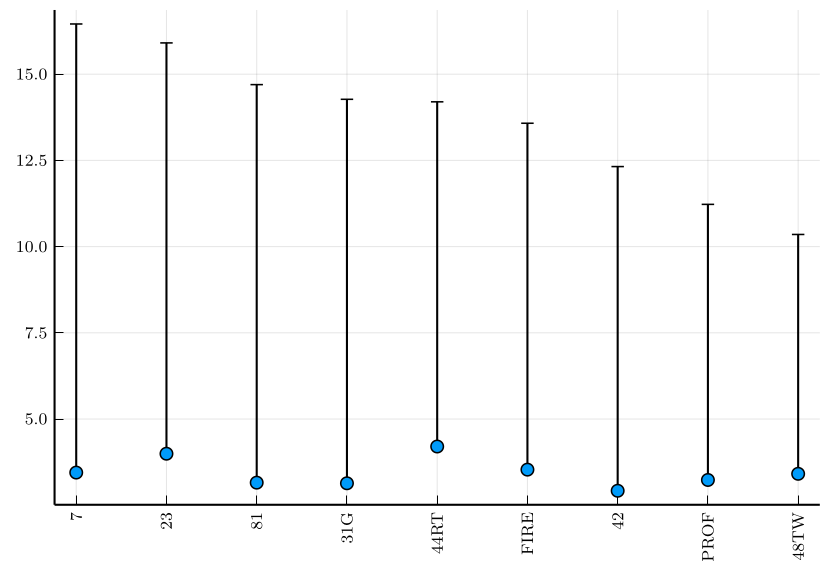

In [19]:
endrow = size(node_conversion_table,1)-1
centralities_plot_raw = plot(   eigenvector_centralities[1:endrow,:Code],
        eigenvector_centralities[1:endrow,:Centrality],
        yerr = (zeros(endrow),
                eigenvector_centralities[1:endrow,:Centrality_error]),
        linetype=:scatter,label="",xrotation=90)
centralities_plot_raw

In [20]:
savefig(centralities_plot,"plots/centrality_intervals_io.svg")
savefig(centralities_plot_raw,"plots/centrality_intervals_io_raw.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/plots/centrality_intervals_io_raw.svg"

Visualise the associated (average) graph of growth rates using a `SimpleWeightedDigraph` object.

In [21]:
#WARNING: both GraphMakie and GraphRecipes export "graphplot"; uses of it in module Main must be qualified
using CairoMakie, GraphMakie, Graphs, SimpleWeightedGraphs, GraphMakie.NetworkLayout
#use GLMakie for the interactive version
#using Karnak, Graphs, SimpleWeightedGraphs, NetworkLayout, Colors
c = exp.(eigenvector_centralities[:,:Centrality]);
g = SimpleWeightedDiGraph(p);
width_vec = 1 .+ zeros(2*p);
width_vec[1:7] =  ones(7);
k=1
for i in 1:p, j in i:p
    add_edge!(g,i,j,graph_estimate[i,j]);
    add_edge!(g,j,i,graph_estimate[j,i]);
    #width_vec[k] = graph_estimate[i,j];
    k += 1;
    #width_vec[k] = graph_estimate[j,i];
    k += 1;
    #println("i ",i," j ",j," ",graph_estimate[i,j])
end

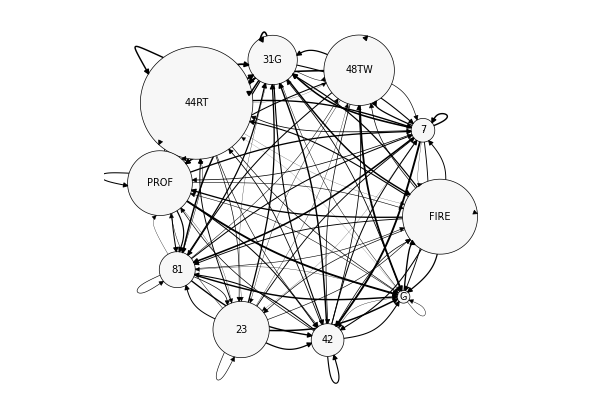

In [32]:
using GraphRecipes #can also use GraphMakie
pythonplot()

gpout = GraphRecipes.graphplot(g,
                        node_weights = c,
                        names  = eigenvector_centralities[:,:Code],
                        nodeshape = :circle,
                        nodesize = .25,
                        nodecolor = "grey97",
                        markerstrokewidth=.5,
                        edgewidth = (s,d,w) -> 10*graph_estimate[s,d],
                        method=:sfdp)



In [33]:
savefig(gpout,"plots/graph_w_centralities_io_raw_simple.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/plots/graph_w_centralities_io_raw_simple.svg"